# **PHASE 1: DATA PREPARATION & MULTI-MODAL FEATURE ENGINEERING**

In [1]:
!pip install faker spacy matplotlib scikit-learn
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import datetime
import spacy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load spaCy model for tokenization and NER
nlp = spacy.load("en_core_web_sm")

**1.1 Data Simulation**

In [3]:
def generate_transaction_data(num_records=1000):
    fake = Faker()
    data = []
    regions = ['North', 'South', 'East', 'West']
    merchants = ['Amazon', 'Walmart', 'Target', 'eBay', 'BestBuy', 'Starbucks']

    for i in range(num_records):
        user_id = fake.uuid4()
        age = random.randint(18, 80)
        region = random.choice(regions)
        credit_score = random.randint(300, 850)
        timestamp = fake.date_time_between(start_date='-1y', end_date='now')
        amount = round(random.uniform(5, 5000), 2)
        merchant = random.choice(merchants)
        ip_address = fake.ipv4()
        device_fingerprint = fake.uuid4()
        location = fake.city()
        browser = random.choice(['Chrome', 'Firefox', 'Safari', 'Edge'])
        session_metadata = fake.sentence(nb_words=6)
        network_latency = round(random.uniform(10, 500), 2)  # in ms
        time_of_day = timestamp.strftime("%H:%M:%S")
        velocity_pattern = round(random.uniform(0.1, 3.0), 2)  # simplified velocity measure
        # Randomly assign labels with a bias toward "normal"
        label = random.choices(['normal', 'suspicious', 'fraudulent'], weights=[0.9, 0.08, 0.02])[0]
        # Construct a text description that will be used for text-based feature extraction
        description = f"{merchant} transaction of ${amount} on {timestamp.strftime('%Y-%m-%d')} via {browser} from IP {ip_address}"

        record = {
            "user_id": user_id,
            "age": age,
            "region": region,
            "credit_score": credit_score,
            "timestamp": timestamp,
            "amount": amount,
            "merchant": merchant,
            "ip_address": ip_address,
            "device_fingerprint": device_fingerprint,
            "location": location,
            "browser": browser,
            "session_metadata": session_metadata,
            "network_latency": network_latency,
            "time_of_day": time_of_day,
            "velocity_pattern": velocity_pattern,
            "description": description,
            "label": label
        }
        data.append(record)
    return pd.DataFrame(data)

# Generate the synthetic transaction dataset
df = generate_transaction_data(num_records=1000)
df.head()


,user_id,age,region,credit_score,timestamp,amount,merchant,ip_address,device_fingerprint,location,browser,session_metadata,network_latency,time_of_day,velocity_pattern,description,label
0,e850ffbb-d904-4496-b4af-8ba7362b4b3c,18,East,472,2024-10-05 08:55:58.970436,2845.58,BestBuy,193.164.190.247,6ac69f2c-2d97-412d-b954-7d6dbfeff1e6,Lake Jonstad,Chrome,View someone inside child cold step.,455.78,08:55:58,1.79,BestBuy transaction of $2845.58 on 2024-10-05 ...,normal
1,6f3fd7df-2068-4208-a83c-8905d1b30ab7,71,North,402,2024-10-31 06:17:29.314738,1892.13,Starbucks,104.141.97.125,329f7a25-3e1e-49d4-855e-240291df26b1,East Andreberg,Edge,Husband sometimes every customer rich return a...,315.72,06:17:29,2.89,Starbucks transaction of $1892.13 on 2024-10-3...,normal
2,6c234892-ad76-44b3-add6-82be2efdb45c,50,East,552,2024-05-03 07:53:16.969949,4133.17,Amazon,115.224.89.167,269c8afe-4a51-42a6-88b7-91503d5a5c0a,Rodrigueztown,Chrome,Charge American much left carry go nothing.,343.74,07:53:16,0.36,Amazon transaction of $4133.17 on 2024-05-03 v...,normal
3,3e27b977-c18d-4ec8-a7e8-2f07545d7eaa,75,South,840,2025-02-28 11:09:07.016614,2478.44,Target,108.153.8.146,5f75d7e8-bea3-4ab7-80c1-ebaace9f58a5,Ashleefort,Firefox,Crime business southern policy light one.,286.47,11:09:07,2.85,Target transaction of $2478.44 on 2025-02-28 v...,suspicious
4,cca43c2b-2527-4d3c-a1d2-0f37437876b2,59,North,419,2024-11-15 23:22:47.750133,2641.37,BestBuy,17.245.114.52,fd1a463e-47d9-46a9-9875-5f2375fd3958,Parkerchester,Chrome,Such approach move line their I suddenly.,340.77,23:22:47,0.33,BestBuy transaction of $2641.37 on 2024-11-15 ...,normal


**1.2 Text‑Based Feature Engineering**

In [4]:
def extract_text_features(text):
    """
    Tokenizes the input text and extracts named entities.
    """
    doc = nlp(text)
    tokens = [token.text for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return tokens, entities

# Test the function on a sample transaction description
sample_text = df.iloc[0]['description']
tokens, entities = extract_text_features(sample_text)
print("Tokens:", tokens)
print("Named Entities:", entities)


Tokens: ['BestBuy', 'transaction', 'of', '$', '2845.58', 'on', '2024', '-', '10', '-', '05', 'via', 'Chrome', 'from', 'IP', '193.164.190.247']
Named Entities: [('BestBuy', 'ORG'), ('2845.58', 'MONEY'), ('2024-10-05', 'DATE'), ('Chrome', 'PRODUCT'), ('IP', 'ORG'), ('193.164.190.247', 'CARDINAL')]


**1.3 Structured Feature Engineering for Numerical Data**

PCA Explained Variance Ratio: [0.97942013 0.01159843 0.0088321 ]


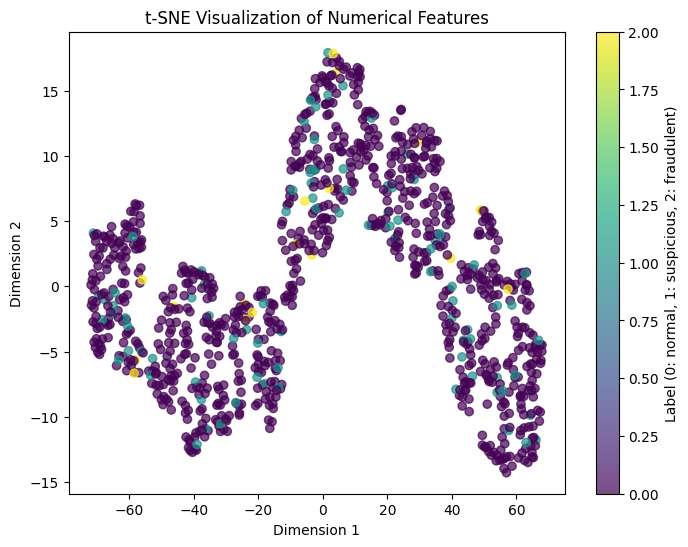

In [5]:
# Select numerical features from the dataset
numerical_data = df[['age', 'credit_score', 'amount', 'network_latency', 'velocity_pattern']].values

# Reduce dimensions using PCA (to 3 components for demonstration)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(numerical_data)
print("PCA Explained Variance Ratio:", pca.explained_variance_ratio_)

# Further reduce to 2 dimensions using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
# Map labels to numeric values for coloring (0:normal, 1:suspicious, 2:fraudulent)
label_map = {'normal': 0, 'suspicious': 1, 'fraudulent': 2}
colors = [label_map[label] for label in df['label']]

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=colors, cmap='viridis', alpha=0.7)
plt.title("t-SNE Visualization of Numerical Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
cbar = plt.colorbar()
cbar.set_label("Label (0: normal, 1: suspicious, 2: fraudulent)")
plt.show()


# **PHASE 2: HYBRID EMBEDDING GENERATION & MULTI-LLM INTEGRATION**

In [6]:
!pip install sentence-transformers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [7]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import random


**2.1 Generate Transaction Embeddings**

In [8]:
# Load pre-trained embedding models
model_simcse = SentenceTransformer('princeton-nlp/sup-simcse-roberta-base')
model_general = SentenceTransformer('all-MiniLM-L6-v2')

def generate_hybrid_embedding(text):
    """
    Generate a combined embedding from two models.
    """
    emb_simcse = model_simcse.encode(text, show_progress_bar=False)
    emb_general = model_general.encode(text, show_progress_bar=False)

    # Ensure both embeddings have the same dimensionality before averaging
    min_dim = min(len(emb_simcse), len(emb_general))
    emb_simcse = emb_simcse[:min_dim]
    emb_general = emb_general[:min_dim]

    # Combine the embeddings (e.g., simple averaging)
    hybrid_embedding = np.mean([emb_simcse, emb_general], axis=0)
    return hybrid_embedding

# Example: Generate embedding for each transaction description in your DataFrame (df from Phase 1)
df['hybrid_embedding'] = df['description'].apply(generate_hybrid_embedding)

# Optionally, convert the embeddings column to a numpy array (for storage or further processing)
embeddings = np.vstack(df['hybrid_embedding'].values)
print("Shape of combined embeddings:", embeddings.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Shape of combined embeddings: (1000, 384)


**2.2 Storing the Embeddings**

In [9]:
np.save('transaction_embeddings.npy', embeddings)

**2.3 Multi‑LLM Fraud Scoring Pipeline**

In [10]:
def gpt4_contextual_score(description):
    """
    Simulated GPT-4 score: Increase risk if description includes very high amounts or unusual terms.
    """
    score = 0
    # Simple heuristic: if the amount in description is high (e.g., > $3000), increase score
    if "$" in description:
        try:
            # Extract the amount by splitting the string (simplistic approach)
            amount_str = description.split("transaction of $")[1].split(" ")[0]
            amount = float(amount_str)
            if amount > 3000:
                score += 0.6
            else:
                score += 0.2
        except Exception as e:
            score += 0.1
    return score

def finbert_categorization_score(description):
    """
    Simulated FinBERT score: Increase risk based on merchant reputation or known suspicious keywords.
    """
    score = 0
    suspicious_merchants = ['eBay', 'Target']  # Example: assume these are sometimes flagged
    for merchant in suspicious_merchants:
        if merchant.lower() in description.lower():
            score += 0.5
    return score

def t5_summarization_score(description):
    """
    Simulated T5 summarization: Check if summarization would flag abnormality.
    (For simplicity, flag if specific keywords appear.)
    """
    score = 0
    keywords = ['fraud', 'suspicious', 'unusual']
    for word in keywords:
        if word in description.lower():
            score += 0.7
    return score

def rl_agent_score(description):
    """
    Simulated RL agent: Use a random factor weighted by certain conditions.
    """
    # For demonstration, return a random score with slight bias if the word 'transaction' is in the description.
    base_score = random.uniform(0, 0.4)
    if 'transaction' in description.lower():
        base_score += 0.1
    return base_score

def compute_fraud_score(description):
    """
    Compute an ensemble fraud score from multiple simulated LLM components.
    """
    score_gpt4 = gpt4_contextual_score(description)
    score_finbert = finbert_categorization_score(description)
    score_t5 = t5_summarization_score(description)
    score_rl = rl_agent_score(description)

    # Combine scores (e.g., by averaging)
    ensemble_score = np.mean([score_gpt4, score_finbert, score_t5, score_rl])
    return ensemble_score

# Apply the fraud scoring function to each transaction
df['fraud_score'] = df['description'].apply(compute_fraud_score)

# Display a sample of the scores
print(df[['description', 'fraud_score']].head())


                                         description  fraud_score
0  BestBuy transaction of $2845.58 on 2024-10-05 ...     0.114350
1  Starbucks transaction of $1892.13 on 2024-10-3...     0.091221
2  Amazon transaction of $4133.17 on 2024-05-03 v...     0.227808
3  Target transaction of $2478.44 on 2025-02-28 v...     0.253436
4  BestBuy transaction of $2641.37 on 2024-11-15 ...     0.155766
